# RF and GBDT on Amazon Review Dataset

In [1]:
#import libraries.....
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.stem.porter import PorterStemmer


#nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_tree
from sklearn import tree
import graphviz 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import time
import datetime
from tqdm import tqdm
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

C:\Users\Administrator\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
start=time.time()
# using the SQLite Table to read data.
# The below SQlite file consists of 60000 rows with Time based splitting and Summary column preprocessed[Feature Engineering].
con = sqlite3.connect('./final_tbs_cleansummary_text.sqlite') 
final_tbs=pd.read_sql_query("""select * from Reviews""",con)
con.close()

end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))

final_tbs.head(5)

00:00:01


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [3]:
#Already done in the loaded file.
'''
final_tbs=final_tbs.sort_values(by=['Time'],ascending=True) # sorted data using Time feature as we need time based splitting
#readable = datetime.datetime.fromtimestamp(1536944119).isoformat()
#print(readable)
final_tbs.head(5)'''

"\nfinal_tbs=final_tbs.sort_values(by=['Time'],ascending=True) # sorted data using Time feature as we need time based splitting\n#readable = datetime.datetime.fromtimestamp(1536944119).isoformat()\n#print(readable)\nfinal_tbs.head(5)"

In [4]:
final_tbs['Score'].value_counts()

positive    51127
negative     8873
Name: Score, dtype: int64

In [5]:
def partition(x):
    if x == "positive":
        return 1
    return 0

actualScore = final_tbs['Score']
positiveNegative = actualScore.map(partition) 
final_tbs['Score'] = positiveNegative

print(final_tbs['Score'].value_counts())

final_tbs.head(5)

1    51127
0     8873
Name: Score, dtype: int64


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [6]:
#Since Summary column gives move details about what the text is, I joined both the features[Feature Engineering].
final_tbs['Summary_CleanedText'] = final_tbs[['Cleaned_Summary', 'CleanedText']].apply(lambda x: ' '.join(x), axis=1)

print(final_tbs['Summary_CleanedText'][0])

everi book educ witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg


In [7]:
final_tbs.head(5)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary,Summary_CleanedText
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ,everi book educ witti littl book make son laug...
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child,whole seri great way spend time child rememb s...
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni,entertainingl funni beetlejuic well written mo...
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale,modern day fairi tale twist rumplestiskin capt...
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast,fantast beetlejuic excel funni movi keaton hil...


In [8]:
def plot_confusion_matrix(y_test, pred):
    C = confusion_matrix(y_test, pred)
    
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [9]:
def plot_heatmap(score,n_estimators,max_depth):
    #, 
    #labels = [50,100,150,200,300]
    #max_depth = [80, 90, 100, 110]
    print("-"*20, "Score", "-"*20)
    plt.figure(figsize=(10,4))
    sns.heatmap(score, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=max_depth, yticklabels=n_estimators)
    plt.xlabel('max_depth')
    plt.ylabel('n_estimators')
    plt.show()

In [10]:
# To print scores
def print_metrics_measure(pred_train,y_1,pred,y_test):
    
     # Plotting Confusion_Matrix
    plot_confusion_matrix(y_test, pred)
    print("******"*20)
    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the LR [Test data] for lambda: ',(acc))
    
    # Precision
    precision = metrics.precision_score(y_test, pred)*100
    print('\nThe precision of the LR [Test data] for lambda: ',(precision))
    
    # Recall
    recall = metrics.recall_score(y_test, pred)*100
    print('\nThe recall of the LR [Test data] for lambda: ',(recall))
    
    print("******"*20)
    
    #F1_Score
    f1_score = metrics.f1_score(y_1, pred_train)*100
    print('\nThe F1_score of the LR [Trian data] for lambda: ',(f1_score))
    
    #F1_Score
    f1_score = metrics.f1_score(y_test, pred)*100
    print('\nThe F1_score of the LR [Test data] for lambda: ',(f1_score))
    
    print("----"*20)

### RANDOM FOREST

In [11]:
def rf(train_std_data,cv_std_data,test_std_data,y_1,y_cv,y_test):
    start=time.time()
    cv_scores = []
   # n_estimators = [100,250,350,500,1000]
   # max_depth = [500,700,1000,1500]
    #splits = [2,5,7,9]
    max_score=0
    estimator=0
    depth1=0
    n_estimators = [10,50,100,200,500,1000]
    max_depth = [25,80,100,110,120,150]
    for est in n_estimators:
        for depth in max_depth:
            rf_clf = RandomForestClassifier(n_estimators=est,criterion='gini',max_depth=depth,oob_score=True,random_state=42)
            rf_clf.fit(train_std_data, y_1)
            pred = rf_clf.predict(cv_std_data)
            #score = rf_clf.oob_score_
            score = metrics.f1_score(y_cv,pred)
            cv_scores.append(score)
            if score > max_score:
                max_score = score
                estimator = est
                depth1 = depth
                
            
    f1_percentage = [x for x in cv_scores]   
    #print(cv_scores)
    clf = RandomForestClassifier(n_estimators=estimator,criterion='gini',max_depth=depth1,random_state=43)
    clf.fit(train_std_data, y_1)
    reshape_f1_percentage = np.reshape(f1_percentage,(6,6))
    print("Estimator: ")
    print(clf)
    print("******"*20)
    plot_heatmap(reshape_f1_percentage,n_estimators,max_depth)
    
    pred_train = clf.predict(train_std_data)
    pred = clf.predict(test_std_data)
    print("******"*20)
    print_metrics_measure(pred_train,y_1,pred,y_test)
    
    end=time.time()-start
    print(time.strftime("%H:%M:%S", time.gmtime(end)))
    return clf

In [12]:
# To print scores
def print_metrics_measure_xgboost(pred_train,y_1,pred_cv,y_cv,pred_test,y_test):
    
     # Plotting Confusion_Matrix
    plot_confusion_matrix(y_test, pred_test)
    print("******"*20)
    # evaluate accuracy
    acc = accuracy_score(y_test, pred_test) * 100
    print('\nThe accuracy of the LR [Test data] for lambda: ',(acc))
    
    # Precision
    precision = metrics.precision_score(y_test, pred_test)*100
    print('\nThe precision of the LR [Test data] for lambda: ',(precision))
    
    # Recall
    recall = metrics.recall_score(y_test, pred_test)*100
    print('\nThe recall of the LR [Test data] for lambda: ',(recall))
    
    print("******"*20)
    #F1_Score
    f1_score = metrics.f1_score(y_1, pred_train)*100
    print('\nThe F1_score of the LR [Train data] for lambda: ',(f1_score))
    
    #F1_Score
    f1_score = metrics.f1_score(y_cv, pred_cv)*100
    print('\nThe F1_score of the LR [CV data] for lambda: ',(f1_score))
    
    #F1_Score
    f1_score = metrics.f1_score(y_test, pred_test)*100
    print('\nThe F1_score of the LR [Test data] for lambda: ',(f1_score))
    
    print("----"*20)

### XGBOOST

In [13]:
def xgb_fn(train_std_data,cv_std_data,test_std_data,y_1,y_cv,y_test):
    start=time.time()
    max_score=0
    estimator=0
    depth1=0
    cv_scores = []
    max_depth = [2,3,5,7,9,10]
    n_estimators = [10,50,100,200,500,1000]
    for est in n_estimators:
        for depth in max_depth:
            xgb_clf = xgb.XGBClassifier(n_estimators=est,max_depth=depth,random_state=42)
            xgb_clf.fit(train_std_data,y_1)      
            pred=xgb_clf.predict(cv_std_data)       
            score = metrics.f1_score(y_cv,pred)
            cv_scores.append(score)
            if score > max_score:
                max_score = score
                estimator = est
                depth1 = depth
        
    f1_percentage = [x for x in cv_scores]  
    #print(cv_scores)
    
    clf = xgb.XGBClassifier(n_estimators=estimator,criterion='gini',max_depth=depth1,random_state=42)
    clf.fit(train_std_data, y_1)
    
    reshape_f1_percentage = np.reshape(f1_percentage,(6,6))
    print("Estimator: ")
    print(clf)
    print("******"*20)
    plot_heatmap(reshape_f1_percentage,n_estimators,max_depth)
    
    pred_train = clf.predict(train_std_data)
    pred_cv = clf.predict(cv_std_data) 
    pred_test = clf.predict(test_std_data)
    print("******"*20)
    print_metrics_measure_xgboost(pred_train,y_1,pred_cv,y_cv,pred_test,y_test)
    
    end=time.time()-start
    print(time.strftime("%H:%M:%S", time.gmtime(end)))
    return clf

In [14]:
# split the data set into train and test
y = np.array(final_tbs['Score'])

In [15]:
#Splitting whole data into Train and Test datasets
X_1, test_df, y_1, y_test = train_test_split(final_tbs, y, test_size=0.20, random_state=43,shuffle=False)
train_df, cv_df, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.20,random_state=43,shuffle=False)

### Bow

In [16]:
#BoW
count_vect = CountVectorizer(min_df=10,max_features=700) #in scikit-learn

train_bows = count_vect.fit_transform(train_df['Summary_CleanedText'])
cv_bows = count_vect.transform(cv_df['Summary_CleanedText'])
test_bows = count_vect.transform(test_df['Summary_CleanedText'])
print(train_bows.shape)
print(cv_bows.shape)
print(test_bows.shape)

(38400, 700)
(9600, 700)
(12000, 700)


In [17]:
features = count_vect.get_feature_names()

Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=43, verbose=0, warm_start=False)
************************************************************************************************************************
-------------------- Score --------------------


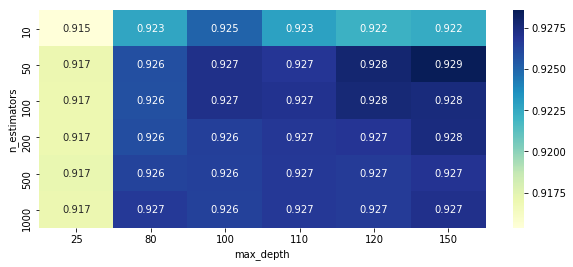

************************************************************************************************************************
-------------------- Confusion matrix --------------------


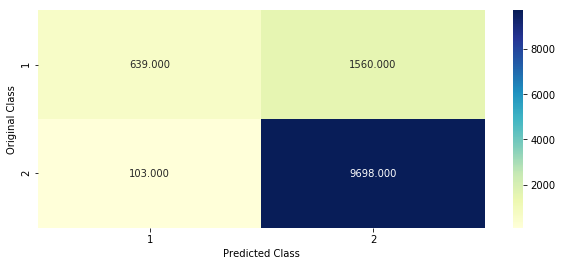

************************************************************************************************************************

The accuracy of the LR [Test data] for lambda:  86.14166666666667

The precision of the LR [Test data] for lambda:  86.14318706697459

The recall of the LR [Test data] for lambda:  98.94908682787471
************************************************************************************************************************

The F1_score of the LR [Trian data] for lambda:  99.97751225582057

The F1_score of the LR [Test data] for lambda:  92.10313880051284
--------------------------------------------------------------------------------
01:27:33


In [18]:

clf_bow_rf = rf(train_bows,cv_bows,test_bows,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.


Estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='gini', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
************************************************************************************************************************
-------------------- Score --------------------


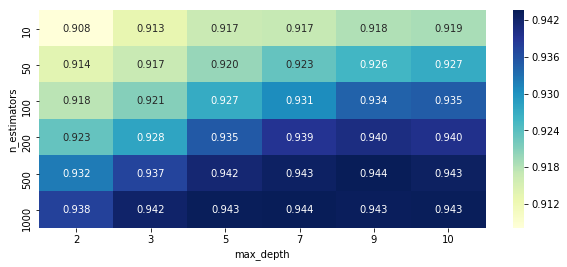

************************************************************************************************************************
-------------------- Confusion matrix --------------------


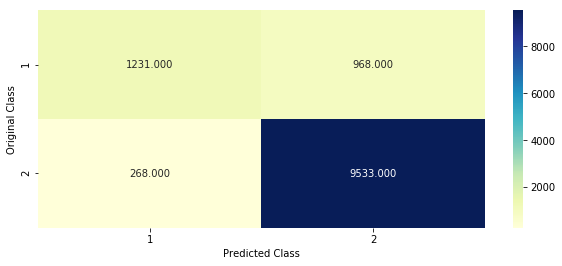

************************************************************************************************************************

The accuracy of the LR [Test data] for lambda:  89.7

The precision of the LR [Test data] for lambda:  90.78183030187601

The recall of the LR [Test data] for lambda:  97.26558514437302
************************************************************************************************************************

The F1_score of the LR [Train data] for lambda:  99.22119774415899

The F1_score of the LR [CV data] for lambda:  94.35660423254683

The F1_score of the LR [Test data] for lambda:  93.91192985912718
--------------------------------------------------------------------------------
00:21:29


In [19]:
clf_bow_xgb = xgb_fn(train_bows,cv_bows,test_bows,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.

### Printing Top 100  features.

In [20]:
def plot_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width = 1500, height = 600, 
                background_color ='white',  
                min_font_size = 10).generate(text) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show()

In [21]:
# coef_  --> Coefficient of the  features in the decision function.

# To check top 100 features after pertubation test.

def show_most_informative_features(vectorizer, clf, n=100):
    text = ' '
    feature_names = vectorizer.get_feature_names()
    #print((clf.coef_[0][1999]))
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    #print(coefs_with_fns[:-11:-1])
    #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top = coefs_with_fns[:-(n + 1):-1]
    for (coef_1, fn_1) in top:
        text = text + fn_1 + ' '
    # To print positive words
    print(" Features: ")
    plot_wordcloud(text)
    

#### XGBOOST Feature Importance

 Features: 


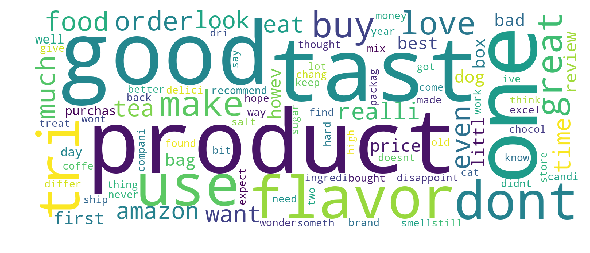

In [22]:
show_most_informative_features(count_vect, clf_bow_xgb)

#### RandomForest Feature Importance

 Features: 


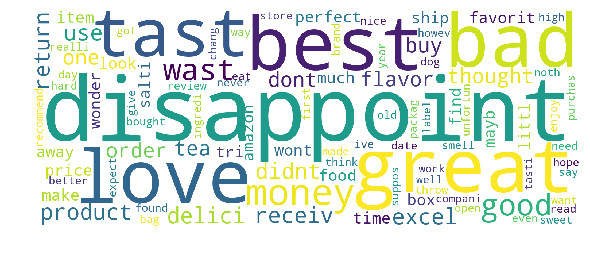

In [23]:
show_most_informative_features(count_vect, clf_bow_rf)

In [24]:
#plot_tree(clf_bow_xgb,num_trees=0, rankdir='LR')

### TFIDF

In [25]:
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=700)

train_tfidf = tf_idf_vect.fit_transform(train_df['Summary_CleanedText'])
cv_tfidf = tf_idf_vect.transform(cv_df['Summary_CleanedText'])
test_tfidf = tf_idf_vect.transform(test_df['Summary_CleanedText'])
print(train_tfidf.shape)
print(cv_tfidf.shape)
print(test_tfidf.shape)

(38400, 700)
(9600, 700)
(12000, 700)


In [26]:
features = tf_idf_vect.get_feature_names()

Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=43, verbose=0, warm_start=False)
************************************************************************************************************************
-------------------- Score --------------------


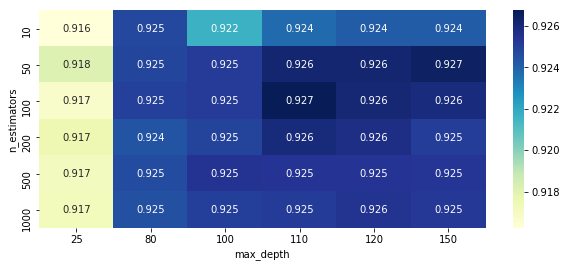

************************************************************************************************************************
-------------------- Confusion matrix --------------------


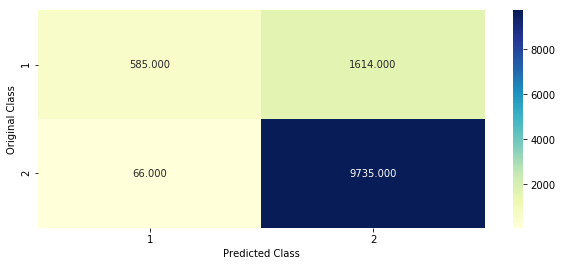

************************************************************************************************************************

The accuracy of the LR [Test data] for lambda:  86.0

The precision of the LR [Test data] for lambda:  85.77848268569917

The recall of the LR [Test data] for lambda:  99.32659932659934
************************************************************************************************************************

The F1_score of the LR [Trian data] for lambda:  99.93256709573973

The F1_score of the LR [Test data] for lambda:  92.05673758865248
--------------------------------------------------------------------------------
01:21:12


In [27]:

clf_tfidf_rf = rf(train_tfidf,cv_tfidf,test_tfidf,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.


Estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='gini', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
************************************************************************************************************************
-------------------- Score --------------------


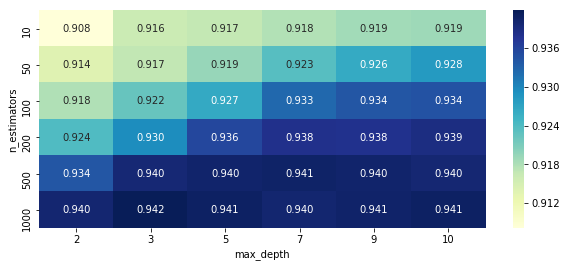

************************************************************************************************************************
-------------------- Confusion matrix --------------------


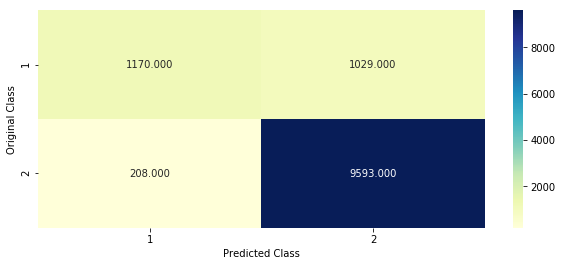

************************************************************************************************************************

The accuracy of the LR [Test data] for lambda:  89.69166666666666

The precision of the LR [Test data] for lambda:  90.3125588401431

The recall of the LR [Test data] for lambda:  97.87776757473728
************************************************************************************************************************

The F1_score of the LR [Train data] for lambda:  97.2865651886168

The F1_score of the LR [CV data] for lambda:  94.18443142701854

The F1_score of the LR [Test data] for lambda:  93.94310336385449
--------------------------------------------------------------------------------
00:46:13


In [28]:
clf_tfidf_xgb = xgb_fn(train_tfidf,cv_tfidf,test_tfidf,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.

### Printing Top 100  features.

#### Random Forest Feature Importance

 Features: 


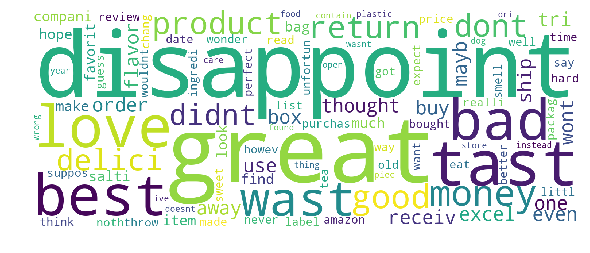

In [29]:
show_most_informative_features(tf_idf_vect, clf_tfidf_rf)

#### XGBOOST Feature Importance

 Features: 


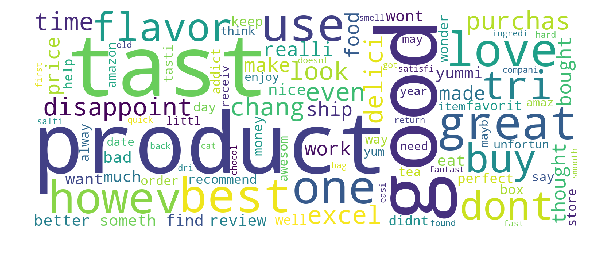

In [30]:
show_most_informative_features(tf_idf_vect, clf_tfidf_xgb)

### Avg-W2V

In [31]:
# We have to train Word2Vec only by using train data.
def train_Word2Vec(list_of_sent):
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model,w2v_words

In [32]:

def avgw2v(list_of_sent,w2v_model,w2v_words):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors


In [33]:
start=time.time()

# Train your own Word2Vec model using your own text corpus
i=0
#train_sent_vectors=[]
#cv_sent_vectors=[]
#test_sent_vectors=[]

list_of_sent=[]
for sent in train_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())

w2v_model,w2v_words = train_Word2Vec(list_of_sent)
train_sent_vectors = avgw2v(list_of_sent,w2v_model,w2v_words)

list_of_sent=[]
for sent in cv_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())

cv_sent_vectors = avgw2v(list_of_sent,w2v_model,w2v_words)

list_of_sent=[]
for sent in test_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())

test_sent_vectors = avgw2v(list_of_sent,w2v_model,w2v_words)
    
end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))

38400
50
9600
50
12000
50
00:01:09


Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=43, verbose=0, warm_start=False)
************************************************************************************************************************
-------------------- Score --------------------


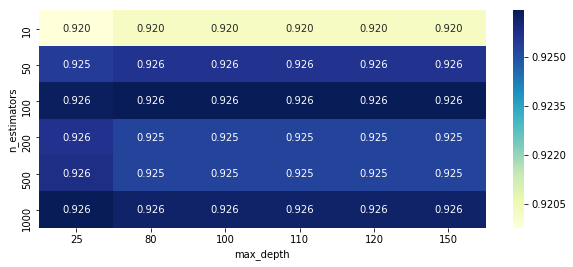

************************************************************************************************************************
-------------------- Confusion matrix --------------------


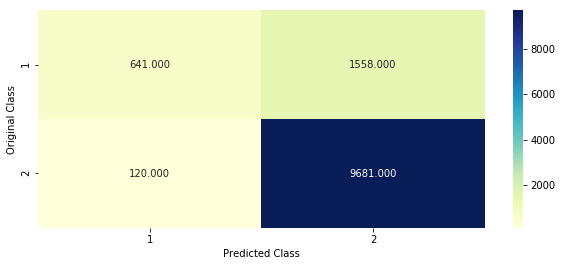

************************************************************************************************************************

The accuracy of the LR [Test data] for lambda:  86.01666666666667

The precision of the LR [Test data] for lambda:  86.13755672212831

The recall of the LR [Test data] for lambda:  98.7756351392715
************************************************************************************************************************

The F1_score of the LR [Trian data] for lambda:  100.0

The F1_score of the LR [Test data] for lambda:  92.02471482889733
--------------------------------------------------------------------------------
00:55:49


In [34]:
clf_avg_w2v_rf = rf(train_sent_vectors,cv_sent_vectors,test_sent_vectors,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.

In [35]:
train_sent_vectors1 = np.array(train_sent_vectors)
cv_sent_vectors1 = np.array(cv_sent_vectors)
test_sent_vectors1 = np.array(test_sent_vectors)

Estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='gini', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
************************************************************************************************************************
-------------------- Score --------------------


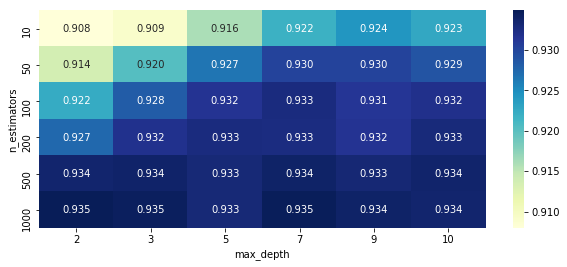

************************************************************************************************************************
-------------------- Confusion matrix --------------------


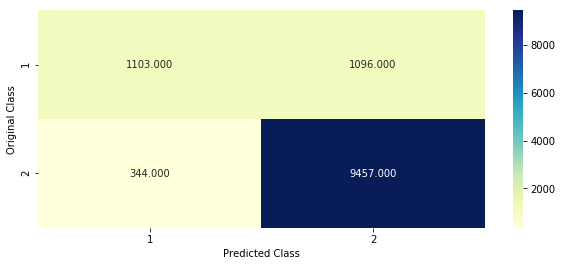

************************************************************************************************************************

The accuracy of the LR [Test data] for lambda:  88.0

The precision of the LR [Test data] for lambda:  89.61432767933289

The recall of the LR [Test data] for lambda:  96.49015406591164
************************************************************************************************************************

The F1_score of the LR [Train data] for lambda:  95.99436983168142

The F1_score of the LR [CV data] for lambda:  93.48904756141837

The F1_score of the LR [Test data] for lambda:  92.92522354328388
--------------------------------------------------------------------------------
00:59:19


In [36]:

clf_avg_w2v_xgb = xgb_fn(train_sent_vectors1,cv_sent_vectors1,test_sent_vectors1,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.


### TFIDF weighted w2v

In [37]:
#Only for train data

def train_Word2Vec(list_of_sent):
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model,w2v_words

def compute_tfidf(list_of_sent,w2v_words,dictionary):
    for sent in list_of_sent:
        for word in sent:
            if word in w2v_words:
                 tf_idf_train_data = dictionary[word]*(sent.count(word)/len(sent)) # Computing tfidf value only with train data.
    return tf_idf_train_data

In [38]:
def tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf):   
    # TF-IDF weighted Word2Vec
    # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
    #model = TfidfVectorizer()
    #tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                #tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [39]:
model = TfidfVectorizer()

start=time.time()

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in train_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
                        
tf_idf_matrix = model.fit_transform(train_df['Summary_CleanedText'].values)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

w2v_model,w2v_words = train_Word2Vec(list_of_sent)

tf_idf_train_data = compute_tfidf(list_of_sent,w2v_words,dictionary)

train_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf_train_data)
 
list_of_sent=[]
for sent in cv_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
    
tf_idf_matrix = model.transform(cv_df['Summary_CleanedText'].values)
cv_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf_train_data)


list_of_sent=[]
for sent in test_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
    
tf_idf_matrix = model.transform(test_df['Summary_CleanedText'].values)
test_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf_train_data)

end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))


100%|█████████████████████████████████████████████████████████████████████| 12000/12000 [00:17<00:00, 674.38it/s]


00:02:12


Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=43, verbose=0, warm_start=False)
************************************************************************************************************************
-------------------- Score --------------------


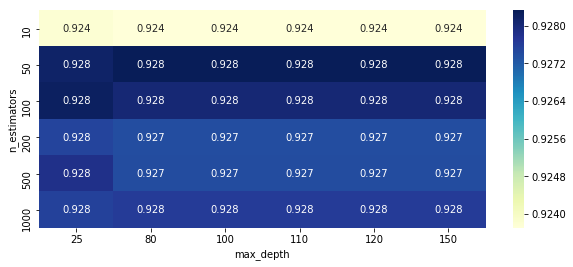

************************************************************************************************************************
-------------------- Confusion matrix --------------------


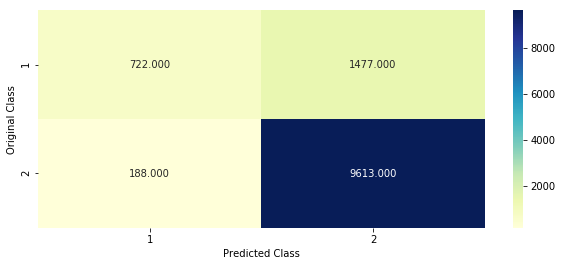

************************************************************************************************************************

The accuracy of the LR [Test data] for lambda:  86.125

The precision of the LR [Test data] for lambda:  86.68169522091975

The recall of the LR [Test data] for lambda:  98.08182838485868
************************************************************************************************************************

The F1_score of the LR [Trian data] for lambda:  99.99400227913394

The F1_score of the LR [Test data] for lambda:  92.0300607917285
--------------------------------------------------------------------------------
00:50:29


In [40]:
clf_tfidf_w2v_rf = rf(train_tfidf_w2v_vectors,cv_tfidf_w2v_vectors,test_tfidf_w2v_vectors,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.

In [41]:
train_tfidf_w2v_vectors1 = np.array(train_tfidf_w2v_vectors)
cv_tfidf_w2v_vectors1 = np.array(cv_tfidf_w2v_vectors)
test_tfidf_w2v_vectors1 = np.array(test_tfidf_w2v_vectors)

Estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='gini', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
************************************************************************************************************************
-------------------- Score --------------------


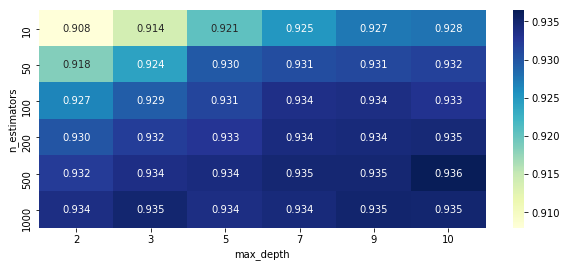

************************************************************************************************************************
-------------------- Confusion matrix --------------------


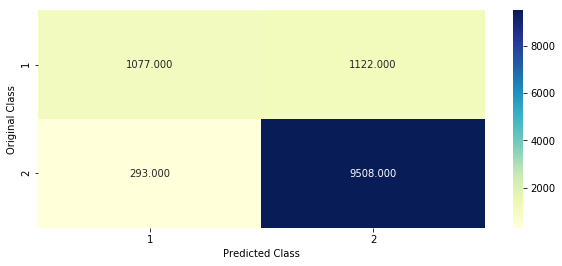

************************************************************************************************************************

The accuracy of the LR [Test data] for lambda:  88.20833333333333

The precision of the LR [Test data] for lambda:  89.44496707431797

The recall of the LR [Test data] for lambda:  97.01050913172125
************************************************************************************************************************

The F1_score of the LR [Train data] for lambda:  100.0

The F1_score of the LR [CV data] for lambda:  93.64427259545674

The F1_score of the LR [Test data] for lambda:  93.07424991434587
--------------------------------------------------------------------------------
01:06:47


In [42]:

clf_tfidf_w2v_xgb = xgb_fn(train_tfidf_w2v_vectors1,cv_tfidf_w2v_vectors1,test_tfidf_w2v_vectors1,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.


# Conclusion:

In [43]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Accuracy", "Precision", "Recall", "F1_Score"]

x.add_row(["BOW","Random Forest",86.08,85.81,99.38,92.10])
x.add_row(["BOW","XGBOOST",89.7,90.78,97.26,93.91])
x.add_row(["TFIDF","Random Forest", 86.175,86.08,99.09,92.13])
x.add_row(["TFIDF","XGBOOST", 89.69,90.31,97.87,93.94])
x.add_row(["Avg-W2V","Random Forest", 85.87,86.01,98.76,91.94])
x.add_row(["Avg-W2V","XGBOOST", 88.45,89.69,97.01,93.21])
x.add_row(["Tfidf-W2V","Random Forest", 86.23,86.48,98.54,92.12])
x.add_row(["Tfidf-W2V","XGBOOST", 88.40,89.87,96.70,93.16])
print(x)

+------------+---------------+----------+-----------+--------+----------+
| Vectorizer |     Model     | Accuracy | Precision | Recall | F1_Score |
+------------+---------------+----------+-----------+--------+----------+
|    BOW     | Random Forest |  86.08   |   85.81   | 99.38  |   92.1   |
|    BOW     |    XGBOOST    |   89.7   |   90.78   | 97.26  |  93.91   |
|   TFIDF    | Random Forest |  86.175  |   86.08   | 99.09  |  92.13   |
|   TFIDF    |    XGBOOST    |  89.69   |   90.31   | 97.87  |  93.94   |
|  Avg-W2V   | Random Forest |  85.87   |   86.01   | 98.76  |  91.94   |
|  Avg-W2V   |    XGBOOST    |  88.45   |   89.69   | 97.01  |  93.21   |
| Tfidf-W2V  | Random Forest |  86.23   |   86.48   | 98.54  |  92.12   |
| Tfidf-W2V  |    XGBOOST    |   88.4   |   89.87   |  96.7  |  93.16   |
+------------+---------------+----------+-----------+--------+----------+
